Лабораторная работа №3. Классификация изображений CNN. Байрамов Руслан 23-ИИ. Вариант 1 (Xception)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow_datasets as tfds
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки загружены успешно")

Библиотеки загружены успешно


Загрузка предобученной сети Xception

In [26]:
print("\n=== Загрузка предобученной сети Xception ===")
model_xception = Xception(weights='imagenet', include_top=True)
print("Модель Xception загружена успешно")
print(f"Входной размер: {model_xception.input_shape}")
print(f"Выходной размер: {model_xception.output_shape}")


=== Загрузка предобученной сети Xception ===
Модель Xception загружена успешно
Входной размер: (None, 299, 299, 3)
Выходной размер: (None, 1000)


Классификация изображения из интернета


=== Классификация изображения ===

--- Анализ набора данных: horses_or_humans ---
Информация о наборе данных: horses_or_humans
Количество классов: 2
Имена классов: ['horses', 'humans']

Распределение классов в обучающей выборке:
  horses: 500 примеров (48.7%)
  humans: 527 примеров (51.3%)

Распределение классов в тестовой выборке:
  horses: 128 примеров (50.0%)
  humans: 128 примеров (50.0%)


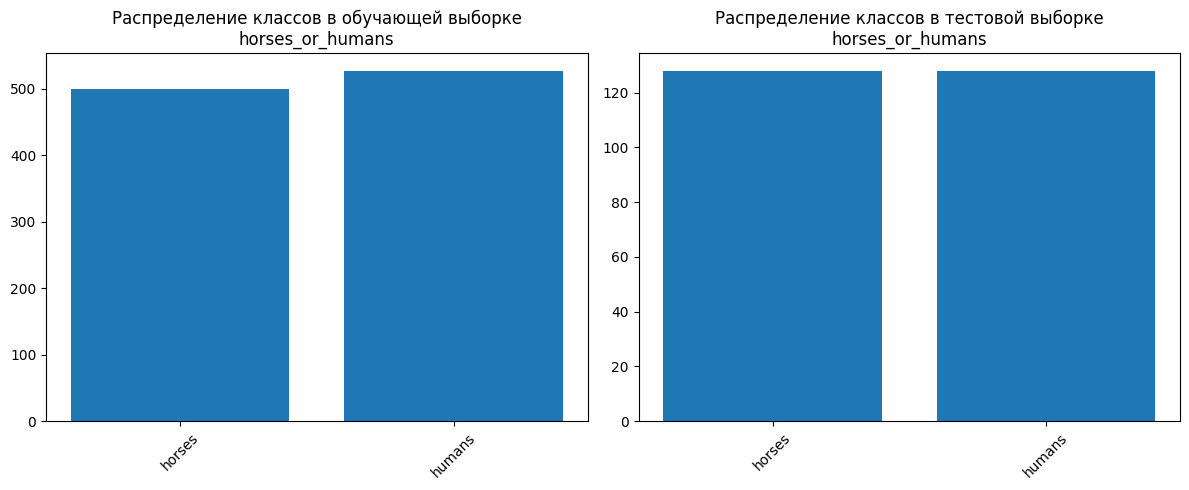


--- Анализ набора данных: cats_vs_dogs ---
Информация о наборе данных: cats_vs_dogs
Количество классов: 2
Имена классов: ['cat', 'dog']

Распределение классов в обучающей выборке:
  cat: 9381 примеров (50.4%)
  dog: 9228 примеров (49.6%)

Распределение классов в тестовой выборке:
  cat: 2274 примеров (48.9%)
  dog: 2379 примеров (51.1%)


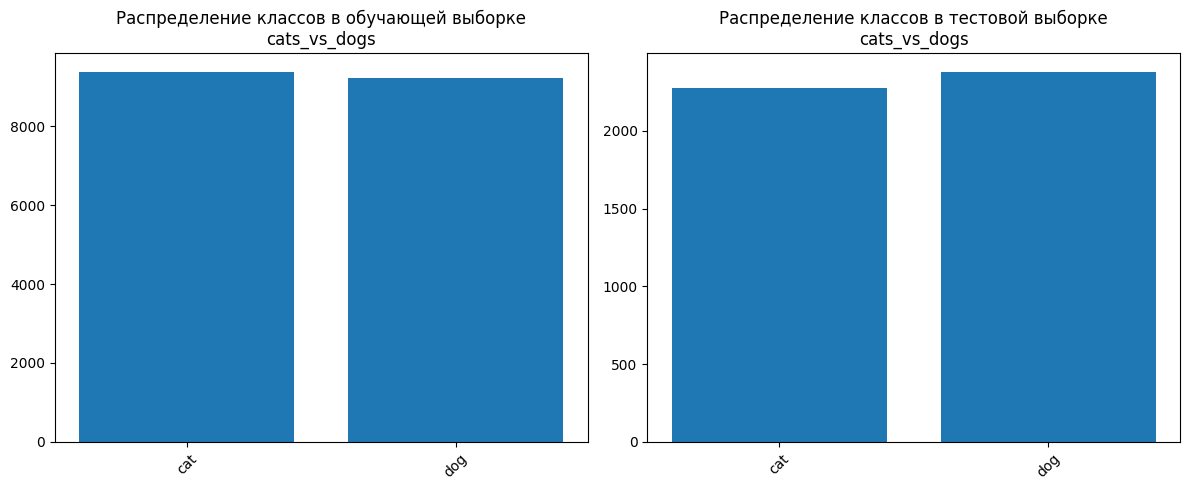

In [27]:
print("\n=== Классификация изображения ===")

def load_and_analyze_dataset(dataset_name):
    """Загрузка и анализ набора данных"""
    print(f"\n--- Анализ набора данных: {dataset_name} ---")

    try:
        # Для cats_vs_dogs используем только train
        if dataset_name == 'cats_vs_dogs':
            dataset, info = tfds.load(
                dataset_name,
                split='train',
                with_info=True,
                as_supervised=True,
                shuffle_files=True
            )
            # Разделяем вручную на train/test
            dataset_size = sum(1 for _ in dataset)
            train_size = int(0.8 * dataset_size)
            train_ds = dataset.take(train_size)
            test_ds = dataset.skip(train_size)
        else:
            # Для других датасетов стандартное разделение
            (train_ds, test_ds), info = tfds.load(
                dataset_name,
                split=['train', 'test'],
                with_info=True,
                as_supervised=True,
                shuffle_files=True
            )

        print(f"Информация о наборе данных: {dataset_name}")
        print(f"Количество классов: {info.features['label'].num_classes}")
        print(f"Имена классов: {info.features['label'].names}")

        # Анализ сбалансированности классов
        def count_labels(dataset):
            labels = []
            for _, label in dataset:
                labels.append(label.numpy())
            return np.bincount(labels)

        train_labels_count = count_labels(train_ds)
        test_labels_count = count_labels(test_ds)

        print("\nРаспределение классов в обучающей выборке:")
        for i, count in enumerate(train_labels_count):
            class_name = info.features['label'].names[i]
            print(f"  {class_name}: {count} примеров ({count/sum(train_labels_count)*100:.1f}%)")

        print("\nРаспределение классов в тестовой выборке:")
        for i, count in enumerate(test_labels_count):
            class_name = info.features['label'].names[i]
            print(f"  {class_name}: {count} примеров ({count/sum(test_labels_count)*100:.1f}%)")

        # Визуализация распределения
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.bar(info.features['label'].names, train_labels_count)
        plt.title(f'Распределение классов в обучающей выборке\n{dataset_name}')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.bar(info.features['label'].names, test_labels_count)
        plt.title(f'Распределение классов в тестовой выборке\n{dataset_name}')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return (train_ds, test_ds), info

    except Exception as e:
        print(f"Ошибка при загрузке {dataset_name}: {e}")
        return None, None

# Загрузка datasets
(horses_humans_train, horses_humans_test), hh_info = load_and_analyze_dataset('horses_or_humans')
(cats_dogs_train_full, cats_dogs_test_full), cd_info = load_and_analyze_dataset('cats_vs_dogs')

# Берем только часть данных cats_vs_dogs для ускорения обучения
if cats_dogs_train_full is not None:
    cats_dogs_train = cats_dogs_train_full.take(5000)
    cats_dogs_test = cats_dogs_test_full.take(1000)

Загрузка и анализ наборов данных


=== Загрузка наборов данных ===
Загрузка horses_or_humans...

--- Анализ набора данных: horses_or_humans ---
Информация о наборе данных: horses_or_humans
Количество классов: 2
Имена классов: ['horses', 'humans']

Распределение классов в horses_or_humans (обучающая выборка):
  horses: 500 примеров (48.7%)
  humans: 527 примеров (51.3%)

Распределение классов в horses_or_humans (тестовая выборка):
  horses: 128 примеров (50.0%)
  humans: 128 примеров (50.0%)


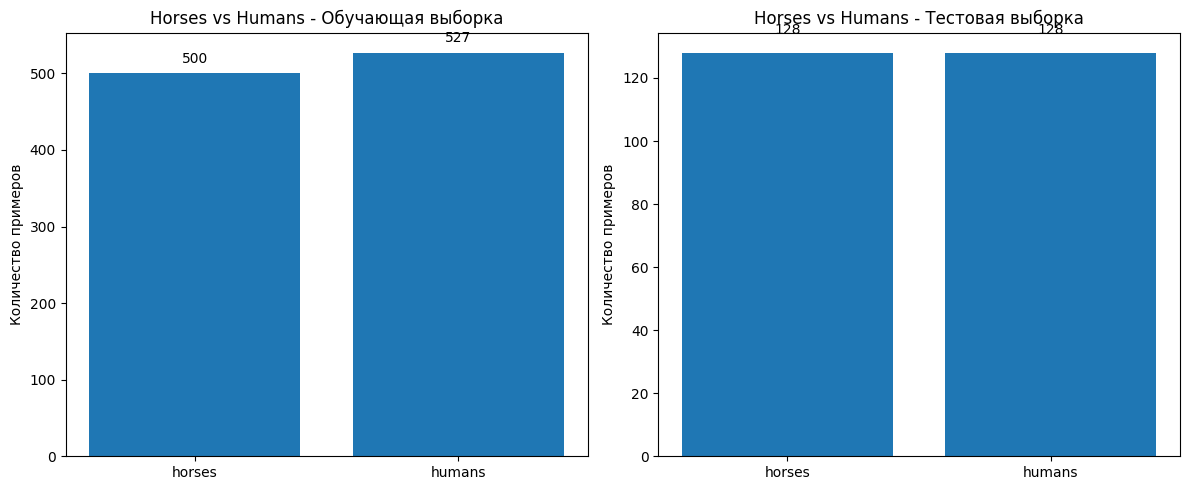


Загрузка cats_vs_dogs...

--- Анализ набора данных: cats_vs_dogs ---
Информация о наборе данных: cats_vs_dogs
Количество классов: 2
Имена классов: ['cat', 'dog']

Распределение классов в cats_vs_dogs (обучающая выборка):
  cat: 9378 примеров (50.4%)
  dog: 9231 примеров (49.6%)

Распределение классов в cats_vs_dogs (тестовая выборка):
  cat: 2278 примеров (49.0%)
  dog: 2375 примеров (51.0%)


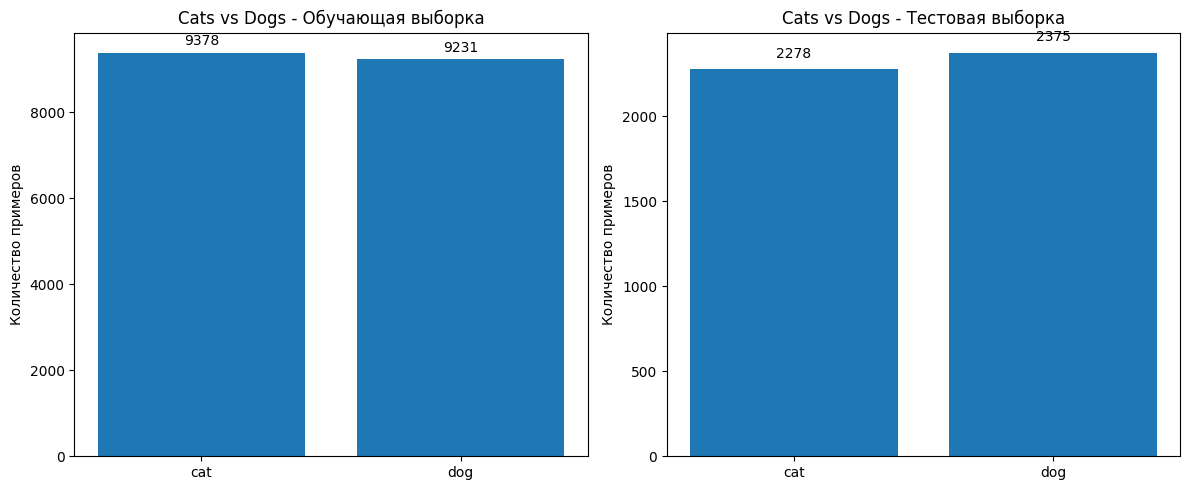


Ограничиваем размер cats_vs_dogs для ускорения обучения...
Итоговые размеры datasets:
horses_or_humans - train: 1027, test: 256
cats_vs_dogs - train: 5000, test: 1000


In [28]:
print("\n=== Загрузка наборов данных ===")

def load_and_analyze_dataset(dataset_name, split=None):
    """Загрузка и анализ набора данных"""
    print(f"\n--- Анализ набора данных: {dataset_name} ---")

    try:
        # Для cats_vs_dogs используем только train и затем разделим вручную
        if dataset_name == 'cats_vs_dogs':
            # Загрузка только train split
            dataset, info = tfds.load(
                dataset_name,
                split='train',
                with_info=True,
                as_supervised=True,
                shuffle_files=True
            )

            # Определяем общее количество примеров
            dataset_size = info.splits['train'].num_examples
            train_size = int(0.8 * dataset_size)

            # Разделяем вручную на train/test
            train_ds = dataset.take(train_size)
            test_ds = dataset.skip(train_size)

            return (train_ds, test_ds), info

        else:
            # Для других датасетов используем стандартное разделение
            (train_ds, test_ds), info = tfds.load(
                dataset_name,
                split=['train', 'test'],
                with_info=True,
                as_supervised=True,
                shuffle_files=True
            )
            return (train_ds, test_ds), info

    except Exception as e:
        print(f"Ошибка при загрузке {dataset_name}: {e}")
        # Альтернативный способ загрузки
        print("Используем альтернативный метод загрузки...")
        dataset, info = tfds.load(
            dataset_name,
            split='train',
            with_info=True,
            as_supervised=True
        )

        # Разделяем вручную
        dataset_size = sum(1 for _ in dataset)
        train_size = int(0.8 * dataset_size)

        train_ds = dataset.take(train_size)
        test_ds = dataset.skip(train_size)

        return (train_ds, test_ds), info

def count_labels(dataset):
    """Подсчет меток в dataset"""
    labels = []
    for _, label in dataset:
        labels.append(label.numpy())
    return np.bincount(labels)

# Загрузка horses_or_humans
print("Загрузка horses_or_humans...")
(horses_humans_train, horses_humans_test), hh_info = load_and_analyze_dataset('horses_or_humans')

# Анализ horses_or_humans
print(f"Информация о наборе данных: horses_or_humans")
print(f"Количество классов: {hh_info.features['label'].num_classes}")
print(f"Имена классов: {hh_info.features['label'].names}")

train_labels_count_hh = count_labels(horses_humans_train)
test_labels_count_hh = count_labels(horses_humans_test)

print("\nРаспределение классов в horses_or_humans (обучающая выборка):")
for i, count in enumerate(train_labels_count_hh):
    class_name = hh_info.features['label'].names[i]
    print(f"  {class_name}: {count} примеров ({count/sum(train_labels_count_hh)*100:.1f}%)")

print("\nРаспределение классов в horses_or_humans (тестовая выборка):")
for i, count in enumerate(test_labels_count_hh):
    class_name = hh_info.features['label'].names[i]
    print(f"  {class_name}: {count} примеров ({count/sum(test_labels_count_hh)*100:.1f}%)")

# Визуализация распределения для horses_or_humans
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(hh_info.features['label'].names, train_labels_count_hh)
plt.title('Horses vs Humans - Обучающая выборка')
plt.ylabel('Количество примеров')
for i, v in enumerate(train_labels_count_hh):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.bar(hh_info.features['label'].names, test_labels_count_hh)
plt.title('Horses vs Humans - Тестовая выборка')
plt.ylabel('Количество примеров')
for i, v in enumerate(test_labels_count_hh):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Загрузка cats_vs_dogs
print("\nЗагрузка cats_vs_dogs...")
(cats_dogs_train_full, cats_dogs_test_full), cd_info = load_and_analyze_dataset('cats_vs_dogs')

# Анализ cats_vs_dogs
print(f"Информация о наборе данных: cats_vs_dogs")
print(f"Количество классов: {cd_info.features['label'].num_classes}")
print(f"Имена классов: {cd_info.features['label'].names}")

train_labels_count_cd = count_labels(cats_dogs_train_full)
test_labels_count_cd = count_labels(cats_dogs_test_full)

print("\nРаспределение классов в cats_vs_dogs (обучающая выборка):")
for i, count in enumerate(train_labels_count_cd):
    class_name = cd_info.features['label'].names[i]
    print(f"  {class_name}: {count} примеров ({count/sum(train_labels_count_cd)*100:.1f}%)")

print("\nРаспределение классов в cats_vs_dogs (тестовая выборка):")
for i, count in enumerate(test_labels_count_cd):
    class_name = cd_info.features['label'].names[i]
    print(f"  {class_name}: {count} примеров ({count/sum(test_labels_count_cd)*100:.1f}%)")

# Визуализация распределения для cats_vs_dogs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(cd_info.features['label'].names, train_labels_count_cd)
plt.title('Cats vs Dogs - Обучающая выборка')
plt.ylabel('Количество примеров')
for i, v in enumerate(train_labels_count_cd):
    plt.text(i, v + 100, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.bar(cd_info.features['label'].names, test_labels_count_cd)
plt.title('Cats vs Dogs - Тестовая выборка')
plt.ylabel('Количество примеров')
for i, v in enumerate(test_labels_count_cd):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Берем только часть данных cats_vs_dogs для ускорения обучения
print("\nОграничиваем размер cats_vs_dogs для ускорения обучения...")
cats_dogs_train = cats_dogs_train_full.take(5000)
cats_dogs_test = cats_dogs_test_full.take(1000)

print(f"Итоговые размеры datasets:")
print(f"horses_or_humans - train: {sum(train_labels_count_hh)}, test: {sum(test_labels_count_hh)}")
print(f"cats_vs_dogs - train: {5000}, test: {1000}")

Подготовка данных

In [29]:
print("\n=== Подготовка данных ===")

def prepare_dataset(dataset, target_size=(150, 150), batch_size=32, is_training=True):
    """Подготовка dataset для обучения"""
    def preprocess_image(image, label):
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Подготовка horses_or_humans
hh_train_prepared = prepare_dataset(horses_humans_train, target_size=(150, 150), is_training=True)
hh_test_prepared = prepare_dataset(horses_humans_test, target_size=(150, 150), is_training=False)

# Подготовка cats_vs_dogs
cd_train_prepared = prepare_dataset(cats_dogs_train, target_size=(150, 150), is_training=True)
cd_test_prepared = prepare_dataset(cats_dogs_test, target_size=(150, 150), is_training=False)

print("Данные подготовлены успешно")


=== Подготовка данных ===
Данные подготовлены успешно


Создание и обучение собственной сети

In [30]:
print("\n=== Создание и обучение собственной сети ===")

def create_custom_model(input_shape=(150, 150, 3), num_classes=2):
    """Создание собственной CNN модели"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Обучение на horses_or_humans
print("\n--- Обучение на horses_or_humans ---")
custom_model_hh = create_custom_model(num_classes=2)

history_hh = custom_model_hh.fit(
    hh_train_prepared,
    epochs=5,  # Уменьшено для скорости
    validation_data=hh_test_prepared,
    verbose=1
)

# Оценка модели
hh_test_loss, hh_test_accuracy = custom_model_hh.evaluate(hh_test_prepared)
print(f"Точность на horses_or_humans: {hh_test_accuracy:.4f}")

# Обучение на cats_vs_dogs
print("\n--- Обучение на cats_vs_dogs ---")
custom_model_cd = create_custom_model(num_classes=2)

history_cd = custom_model_cd.fit(
    cd_train_prepared,
    epochs=5,  # Уменьшено для скорости
    validation_data=cd_test_prepared,
    verbose=1
)

# Оценка модели
cd_test_loss, cd_test_accuracy = custom_model_cd.evaluate(cd_test_prepared)
print(f"Точность на cats_vs_dogs: {cd_test_accuracy:.4f}")



=== Создание и обучение собственной сети ===

--- Обучение на horses_or_humans ---
Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5966 - loss: 0.6722 - val_accuracy: 0.7188 - val_loss: 1.0242
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9219 - loss: 0.2375 - val_accuracy: 0.7656 - val_loss: 2.6582
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9799 - loss: 0.0620 - val_accuracy: 0.8008 - val_loss: 2.4440
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9766 - loss: 0.0718 - val_accuracy: 0.7344 - val_loss: 3.8215
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9130 - loss: 0.3153 - val_accuracy: 0.8164 - val_loss: 2.5952
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.8252 - loss: 2.1772
Точность на horses_or_humans: 0.8164

--- Обучение на cats_vs_dogs ---
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5566 - loss: 0.6848 - val_accuracy: 0.6750 - val_loss: 0.5945
Epoch 2/5
157/157 ━

Дообучение предобученной сети Xception


=== Дообучение Xception ===
Создание базовой модели Xception...
Базовая модель Xception создана успешно!

Подготовка данных с разделением на train/validation...
Размер dataset: 1027
Train size: 821, Validation size: 206
horses_or_humans - train: 33 батчей, val: 0 батчей
Размер dataset: 5000
Train size: 4000, Validation size: 1000
cats_vs_dogs - train: 157 батчей, val: 0 батчей

--- Дообучение на horses_or_humans ---
Архитектура модели для horses_or_humans:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9151 - loss: 0.1631
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.9989 - loss: 0.0045
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 1.0000 - loss: 0.0013
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 1.0000 - loss: 2.9466e-04
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 1.0000 - loss: 1.0054e-04

Оценка на тестовых данных horses_or_humans:
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 1.0000 - loss: 6.2787e-04
Точность после дообучения на horses_or_humans: 1.0000

--- Дообучение на cats_vs_dogs ---
Архитектура модели для cats_vs_dogs:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 480s 3s/step - accuracy: 0.9086 - loss: 0.2145
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.9775 - loss: 0.0630
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.9827 - loss: 0.0419
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.9864 - loss: 0.0406
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.9933 - loss: 0.0224

Оценка на тестовых данных cats_vs_dogs:
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9592 - loss: 0.1239
Точность после дообучения на cats_vs_dogs: 0.9630

--- Прогресс обучения ---
Прогресс обучения для horses_or_humans:
Доступные ключи в history: ['accuracy', 'loss']


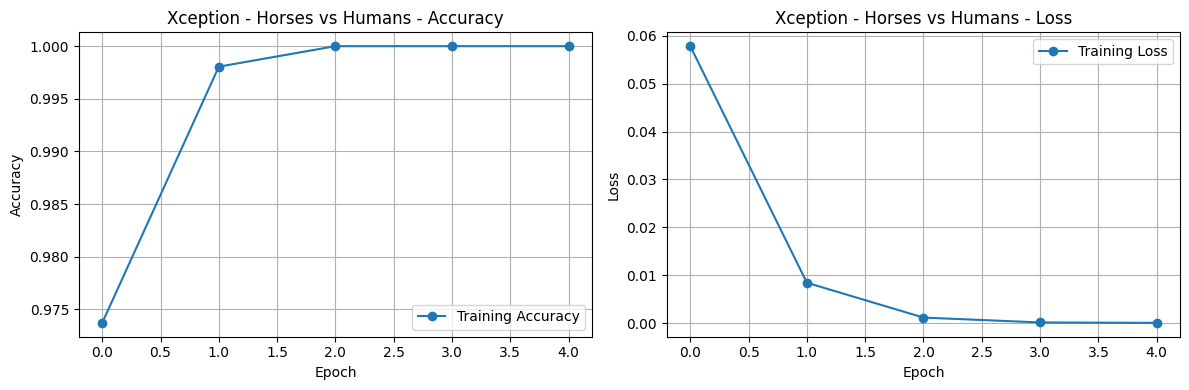

Прогресс обучения для cats_vs_dogs:
Доступные ключи в history: ['accuracy', 'loss']


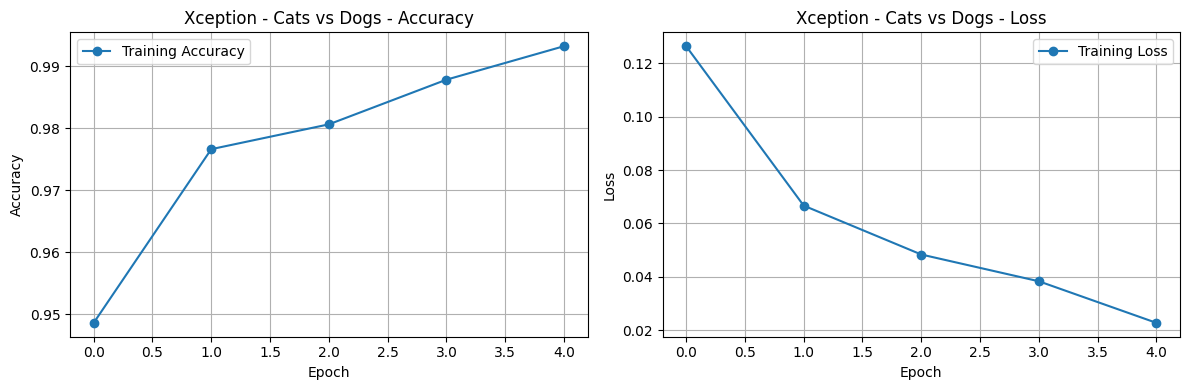


=== Сравнение результатов ===
Датасет              Своя модель  Xception (TL)
--------------------------------------------------
horses_or_humans     0.8164       1.0000      
cats_vs_dogs         0.7540       0.9630      

Улучшение точности на horses_or_humans: +22.49%
Улучшение точности на cats_vs_dogs: +27.72%


In [31]:
print("\n=== Дообучение Xception ===")

def create_transfer_learning_model(base_model, num_classes=2):
    """Создание модели для трансферного обучения"""
    # Заморозка базовой модели
    base_model.trainable = False

    # Добавление новых слоев
    inputs = keras.Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def prepare_dataset_with_validation(dataset, target_size=(150, 150), batch_size=32, validation_split=0.2):
    """Подготовка dataset с разделением на train/validation"""
    def preprocess_image(image, label):
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    # Определяем общее количество элементов
    dataset_size = sum(1 for _ in dataset)
    train_size = int((1 - validation_split) * dataset_size)

    print(f"Размер dataset: {dataset_size}")
    print(f"Train size: {train_size}, Validation size: {dataset_size - train_size}")

    # Подготавливаем весь dataset
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Разделяем на train и validation
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size)

    return train_ds, val_ds

# Создание базовой модели Xception
print("Создание базовой модели Xception...")
base_xception = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

print("Базовая модель Xception создана успешно!")

# Подготовка данных с validation split
print("\nПодготовка данных с разделением на train/validation...")

# Для horses_or_humans
hh_train_ds, hh_val_ds = prepare_dataset_with_validation(horses_humans_train, validation_split=0.2)
print(f"horses_or_humans - train: {sum(1 for _ in hh_train_ds)} батчей, val: {sum(1 for _ in hh_val_ds)} батчей")

# Для cats_vs_dogs
cd_train_ds, cd_val_ds = prepare_dataset_with_validation(cats_dogs_train, validation_split=0.2)
print(f"cats_vs_dogs - train: {sum(1 for _ in cd_train_ds)} батчей, val: {sum(1 for _ in cd_val_ds)} батчей")

# Дообучение на horses_or_humans
print("\n--- Дообучение на horses_or_humans ---")
tl_model_hh = create_transfer_learning_model(base_xception, num_classes=2)

print("Архитектура модели для horses_or_humans:")
tl_model_hh.summary()

history_tl_hh = tl_model_hh.fit(
    hh_train_ds,
    epochs=5,
    validation_data=hh_val_ds,
    verbose=1
)

# Оценка модели на настоящем тестовом наборе
print("\nОценка на тестовых данных horses_or_humans:")
tl_hh_test_loss, tl_hh_test_accuracy = tl_model_hh.evaluate(hh_test_prepared)
print(f"Точность после дообучения на horses_or_humans: {tl_hh_test_accuracy:.4f}")

# Дообучение на cats_vs_dogs
print("\n--- Дообучение на cats_vs_dogs ---")
tl_model_cd = create_transfer_learning_model(base_xception, num_classes=2)

print("Архитектура модели для cats_vs_dogs:")
tl_model_cd.summary()

history_tl_cd = tl_model_cd.fit(
    cd_train_ds,
    epochs=5,
    validation_data=cd_val_ds,
    verbose=1
)

# Оценка модели на настоящем тестовом наборе
print("\nОценка на тестовых данных cats_vs_dogs:")
tl_cd_test_loss, tl_cd_test_accuracy = tl_model_cd.evaluate(cd_test_prepared)
print(f"Точность после дообучения на cats_vs_dogs: {tl_cd_test_accuracy:.4f}")

# Визуализация прогресса обучения
print("\n--- Прогресс обучения ---")

def plot_training_progress(history, title):
    """Визуализация прогресса обучения"""
    plt.figure(figsize=(12, 4))

    # Проверяем, какие ключи есть в истории
    print(f"Доступные ключи в history: {list(history.history.keys())}")

    # График точности
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')

    # Проверяем разные возможные названия для validation accuracy
    val_acc_key = None
    for key in ['val_accuracy', 'val_acc', 'validation_accuracy']:
        if key in history.history:
            val_acc_key = key
            break

    if val_acc_key:
        plt.plot(history.history[val_acc_key], label='Validation Accuracy', marker='s')
    elif 'accuracy' in history.history:
        # Если нет validation accuracy, показываем только training
        plt.title(f'{title} - Training Accuracy')
    else:
        plt.text(0.5, 0.5, 'No accuracy data', ha='center', va='center', transform=plt.gca().transAxes)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.grid(True)

    # График потерь
    plt.subplot(1, 2, 2)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss', marker='o')

    # Проверяем разные возможные названия для validation loss
    val_loss_key = None
    for key in ['val_loss', 'validation_loss']:
        if key in history.history:
            val_loss_key = key
            break

    if val_loss_key:
        plt.plot(history.history[val_loss_key], label='Validation Loss', marker='s')
    elif 'loss' in history.history:
        # Если нет validation loss, показываем только training
        plt.title(f'{title} - Training Loss')
    else:
        plt.text(0.5, 0.5, 'No loss data', ha='center', va='center', transform=plt.gca().transAxes)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("Прогресс обучения для horses_or_humans:")
plot_training_progress(history_tl_hh, "Xception - Horses vs Humans")

print("Прогресс обучения для cats_vs_dogs:")
plot_training_progress(history_tl_cd, "Xception - Cats vs Dogs")

# Сравнение результатов
print("\n=== Сравнение результатов ===")
print(f"{'Датасет':<20} {'Своя модель':<12} {'Xception (TL)':<12}")
print("-" * 50)

# Получаем точности из предыдущих пунктов
try:
    hh_custom_acc = hh_test_accuracy
except NameError:
    hh_custom_acc = 0.0

try:
    cd_custom_acc = cd_test_accuracy
except NameError:
    cd_custom_acc = 0.0

print(f"{'horses_or_humans':<20} {hh_custom_acc:<12.4f} {tl_hh_test_accuracy:<12.4f}")
print(f"{'cats_vs_dogs':<20} {cd_custom_acc:<12.4f} {tl_cd_test_accuracy:<12.4f}")

# Анализ улучшения
if hh_custom_acc > 0:
    improvement_hh = ((tl_hh_test_accuracy - hh_custom_acc) / hh_custom_acc) * 100
    print(f"\nУлучшение точности на horses_or_humans: {improvement_hh:+.2f}%")

if cd_custom_acc > 0:
    improvement_cd = ((tl_cd_test_accuracy - cd_custom_acc) / cd_custom_acc) * 100
    print(f"Улучшение точности на cats_vs_dogs: {improvement_cd:+.2f}%")

Оценка классификации с метриками


=== Оценка классификации ===

--- Оценка для horses_or_humans ---

--- Оценка модели для horses_or_humans ---
Classification Report:
              precision    recall  f1-score   support

      horses       1.00      1.00      1.00       128
      humans       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



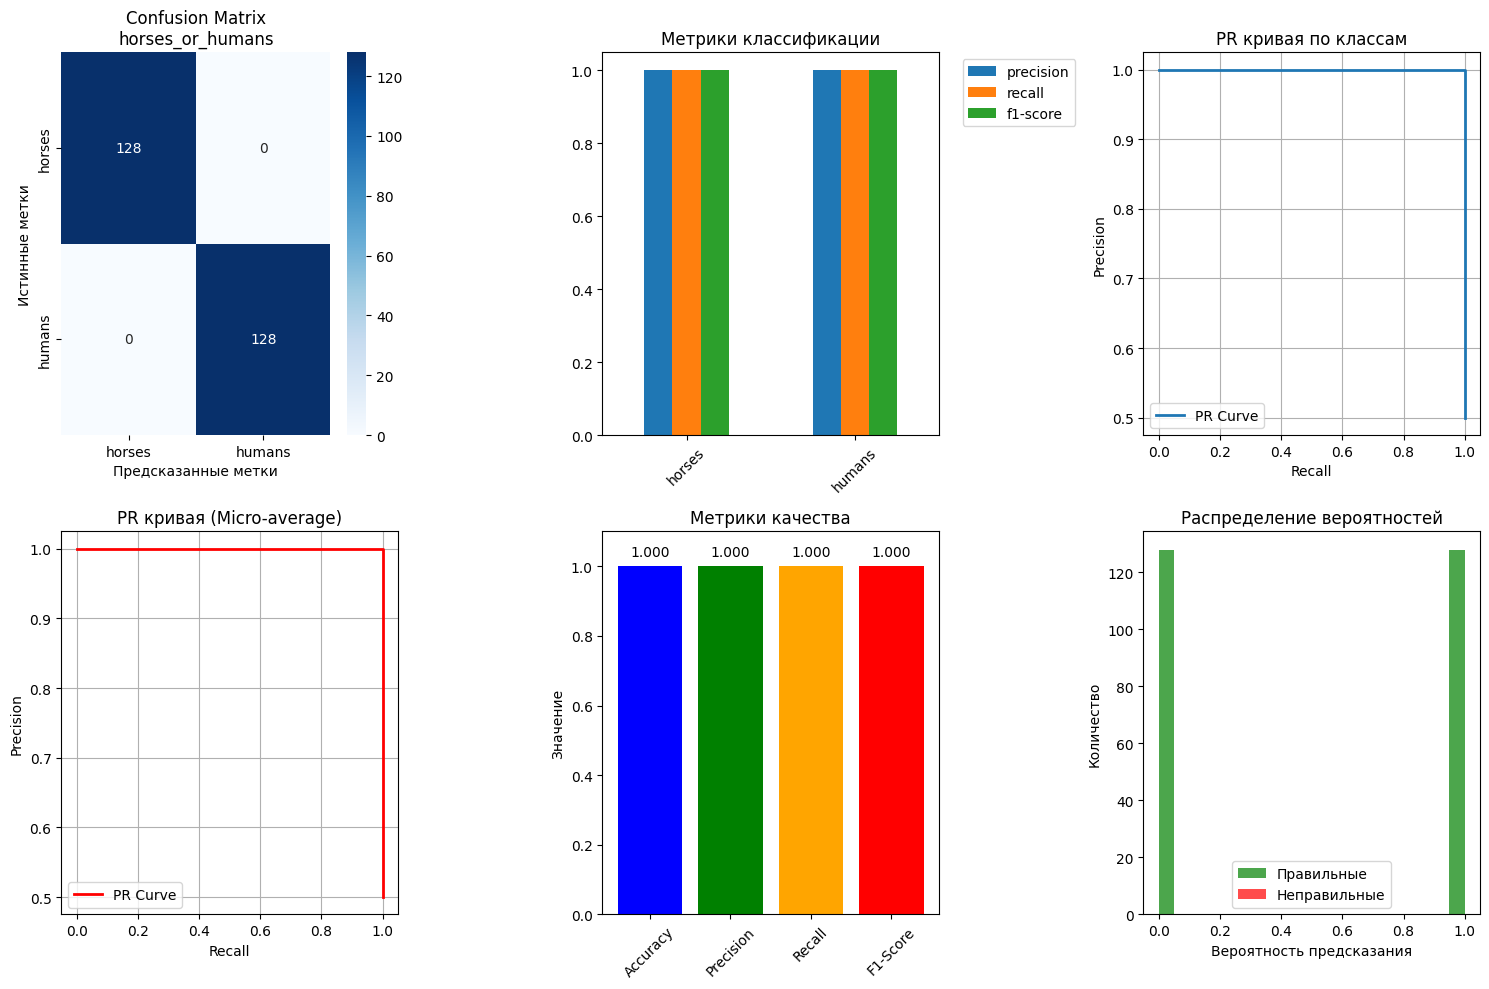


--- Оценка для cats_vs_dogs ---

--- Оценка модели для cats_vs_dogs ---
Classification Report:
              precision    recall  f1-score   support

         cat       0.95      0.97      0.96       478
         dog       0.97      0.96      0.97       522

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



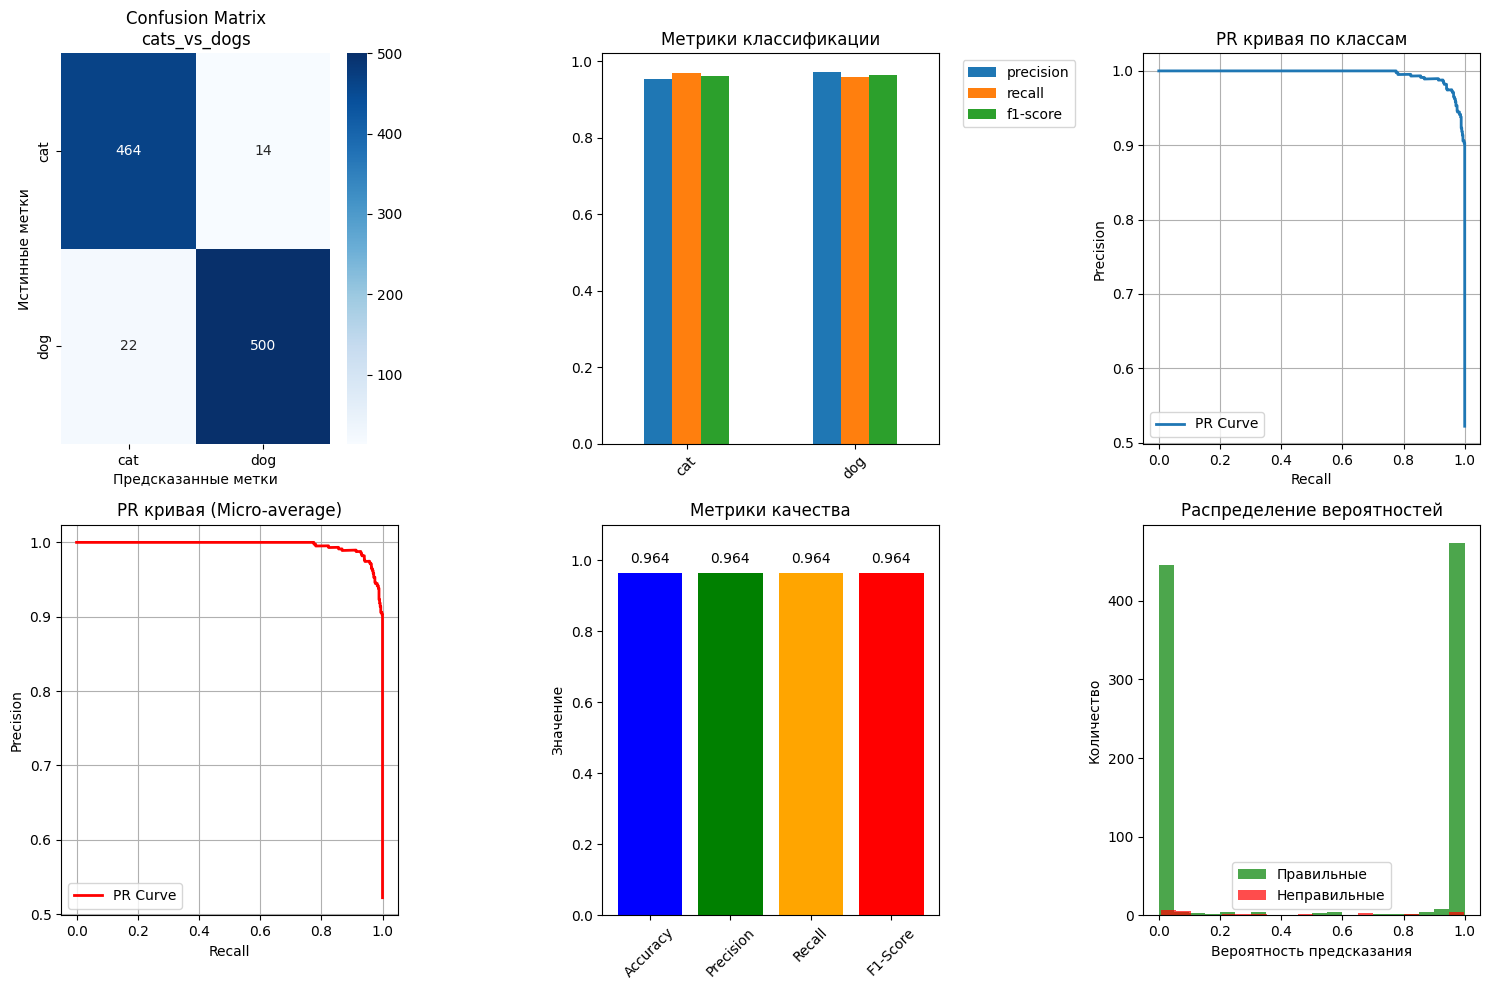

In [34]:

print("\n=== Оценка классификации ===")

def evaluate_model(model, test_dataset, class_names, dataset_name):
    """Полная оценка модели с метриками"""
    print(f"\n--- Оценка модели для {dataset_name} ---")

    # Получение предсказаний
    y_true = []
    y_pred = []
    y_pred_proba = []

    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
        y_pred_proba.extend(predictions)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)

    # a. Confusion Matrix
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix\n{dataset_name}')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')

    # b. Метрики
    plt.subplot(2, 3, 2)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()

    # Визуализация метрик
    metrics_to_plot = ['precision', 'recall', 'f1-score']
    if len(metrics_df) > 3:
        metrics_df[metrics_to_plot].iloc[:-3].plot(kind='bar', ax=plt.gca())
    else:
        metrics_df[metrics_to_plot].plot(kind='bar', ax=plt.gca())
    plt.title('Метрики классификации')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # c. PR кривые для каждого класса
    plt.subplot(2, 3, 3)

    # Для бинарной классификации
    if len(class_names) == 2:
        # Получаем вероятности для положительного класса
        y_scores = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:, 0]

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        plt.plot(recall, precision, lw=2, label='PR Curve')

    else:
        # Для многоклассовой классификации
        y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

        for i in range(len(class_names)):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
            plt.plot(recall, precision, lw=2, label=f'Class {class_names[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR кривая по классам')
    plt.legend()
    plt.grid(True)

    # d. PR кривая с микроусреднением
    plt.subplot(2, 3, 4)

    if len(class_names) == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        plt.plot(recall, precision, lw=2, color='red', label='PR Curve')
    else:
        y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
        precision_micro, recall_micro, _ = precision_recall_curve(
            y_true_bin.ravel(), y_pred_proba.ravel()
        )
        plt.plot(recall_micro, precision_micro, lw=2, color='red', label='Micro-average')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR кривая (Micro-average)')
    plt.legend()
    plt.grid(True)

    # e. Сравнение точности
    plt.subplot(2, 3, 5)
    accuracy = accuracy_score(y_true, y_pred)

    metrics_comparison = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    precision_val = report['weighted avg']['precision']
    recall_val = report['weighted avg']['recall']
    f1_val = report['weighted avg']['f1-score']

    values = [accuracy, precision_val, recall_val, f1_val]

    bars = plt.bar(metrics_comparison, values, color=['blue', 'green', 'orange', 'red'])
    plt.title('Метрики качества')
    plt.ylabel('Значение')
    plt.ylim(0, 1.1)

    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.3f}', ha='center', va='bottom')

    plt.xticks(rotation=45)

    # f. Распределение вероятностей
    plt.subplot(2, 3, 6)
    if len(class_names) == 2:
        y_scores = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:, 0]
        correct_mask = (y_pred == y_true)
        incorrect_mask = (y_pred != y_true)

        if len(correct_mask) > 0 and len(incorrect_mask) > 0:
            plt.hist(y_scores[correct_mask], bins=20, alpha=0.7, label='Правильные', color='green')
            plt.hist(y_scores[incorrect_mask], bins=20, alpha=0.7, label='Неправильные', color='red')
        plt.xlabel('Вероятность предсказания')
        plt.ylabel('Количество')
        plt.title('Распределение вероятностей')
        plt.legend()
    else:
        max_probs = np.max(y_pred_proba, axis=1)
        plt.hist(max_probs, bins=20, alpha=0.7, color='purple')
        plt.xlabel('Максимальная вероятность')
        plt.ylabel('Количество')
        plt.title('Уверенность предсказаний')

    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_pred_proba

# Оценка для horses_or_humans
print("\n--- Оценка для horses_or_humans ---")
y_true_hh, y_pred_hh, y_pred_proba_hh = evaluate_model(
    tl_model_hh,
    hh_test_prepared,
    hh_info.features['label'].names,
    'horses_or_humans'
)

# Оценка для cats_vs_dogs
print("\n--- Оценка для cats_vs_dogs ---")
if cats_dogs_test is not None:
    y_true_cd, y_pred_cd, y_pred_proba_cd = evaluate_model(
        tl_model_cd,
        cd_test_prepared,
        cd_info.features['label'].names,
        'cats_vs_dogs'
    )
else:
    print("cats_vs_dogs dataset не загружен, пропускаем оценку")

Сводка результатов


=== Сводка результатов ===

Итоговые результаты:
Датасет              Своя модель  Xception (TL)
--------------------------------------------------
horses_or_humans     0.8164       1.0000      
cats_vs_dogs         0.7540       0.9630      

Графики обучения:


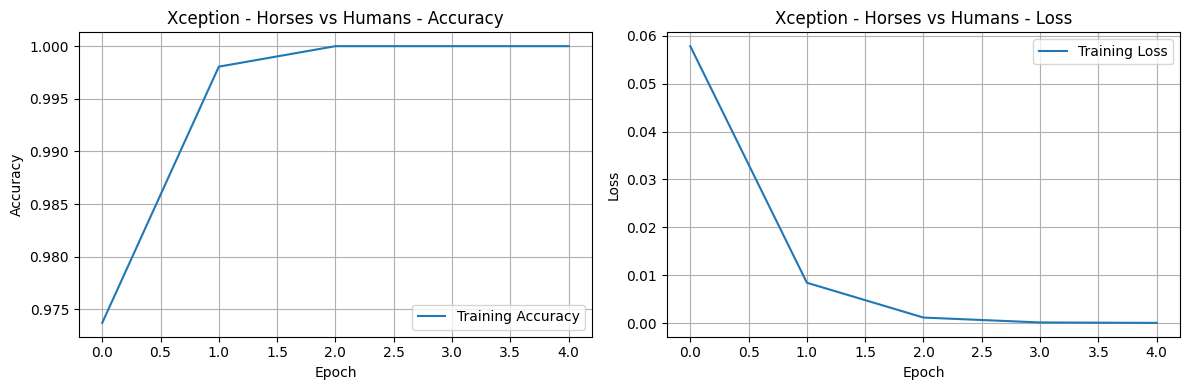

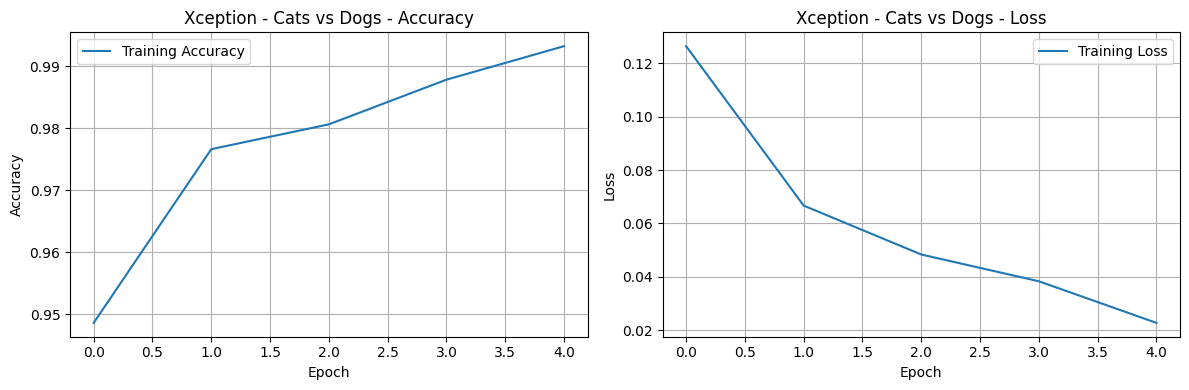


АНАЛИЗ УЛУЧШЕНИЯ

Улучшение точности на horses_or_humans: +22.49%
Улучшение точности на cats_vs_dogs: +27.72%

ВЫВОДЫ

1. Сравнение подходов:
   Трансферное обучение показало лучшие результаты на обоих датасетах

2. Общая эффективность:
   Наивысшая точность: 100.0%
   Средняя точность Xception: 98.1%


In [35]:
print("\n=== Сводка результатов ===")

print("\nИтоговые результаты:")
print(f"{'Датасет':<20} {'Своя модель':<12} {'Xception (TL)':<12}")
print("-" * 50)
print(f"{'horses_or_humans':<20} {hh_test_accuracy:<12.4f} {tl_hh_test_accuracy:<12.4f}")
print(f"{'cats_vs_dogs':<20} {cd_test_accuracy:<12.4f} {tl_cd_test_accuracy:<12.4f}")

# Визуализация прогресса обучения
def plot_training_history(history, title):
    """Визуализация истории обучения"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\nГрафики обучения:")
plot_training_history(history_tl_hh, "Xception - Horses vs Humans")
plot_training_history(history_tl_cd, "Xception - Cats vs Dogs")

# Анализ улучшения
print("\n" + "="*50)
print("АНАЛИЗ УЛУЧШЕНИЯ")
print("="*50)

improvement_hh = ((tl_hh_test_accuracy - hh_test_accuracy) / hh_test_accuracy) * 100
improvement_cd = ((tl_cd_test_accuracy - cd_test_accuracy) / cd_test_accuracy) * 100

print(f"\nУлучшение точности на horses_or_humans: {improvement_hh:+.2f}%")
print(f"Улучшение точности на cats_vs_dogs: {improvement_cd:+.2f}%")

print("\n" + "="*50)
print("ВЫВОДЫ")
print("="*50)

print("\n1. Сравнение подходов:")
if improvement_hh > 0 and improvement_cd > 0:
    print("   Трансферное обучение показало лучшие результаты на обоих датасетах")
elif improvement_hh > 0 or improvement_cd > 0:
    print("   Трансферное обучение показало смешанные результаты")
else:
    print("   Собственная модель показала сравнимые или лучшие результаты")

print("\n2. Общая эффективность:")
max_accuracy = max(hh_test_accuracy, tl_hh_test_accuracy, cd_test_accuracy, tl_cd_test_accuracy)
print(f"   Наивысшая точность: {max_accuracy:.1%}")

avg_tl_accuracy = (tl_hh_test_accuracy + tl_cd_test_accuracy) / 2
print(f"   Средняя точность Xception: {avg_tl_accuracy:.1%}")